Datos simulados de EUR/USD (primeras 10 filas):
              precio
fecha               
2023-01-01  1.052484
2023-01-02  1.057267
2023-01-03  1.063268
2023-01-04  1.062375
2023-01-05  1.045052
2023-01-06  1.039781
2023-01-07  1.050919
2023-01-08  1.054819
2023-01-09  1.056593
2023-01-10  1.063725


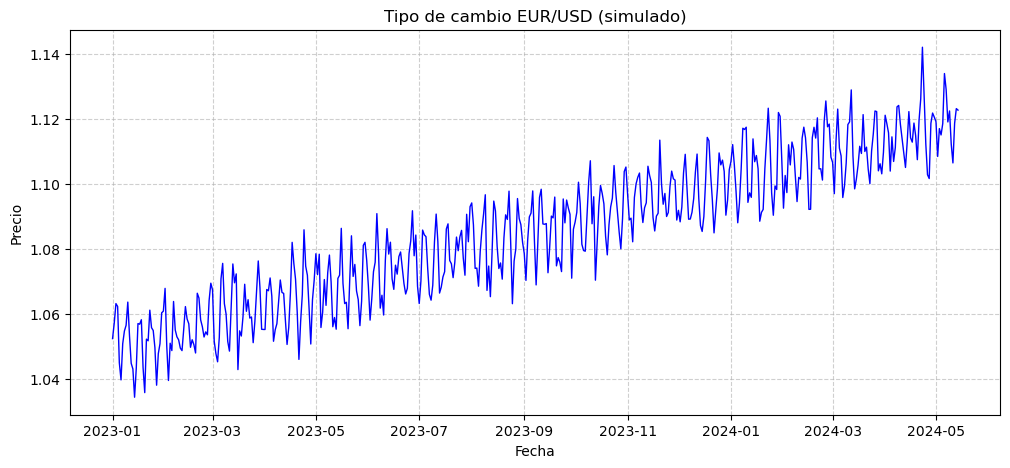

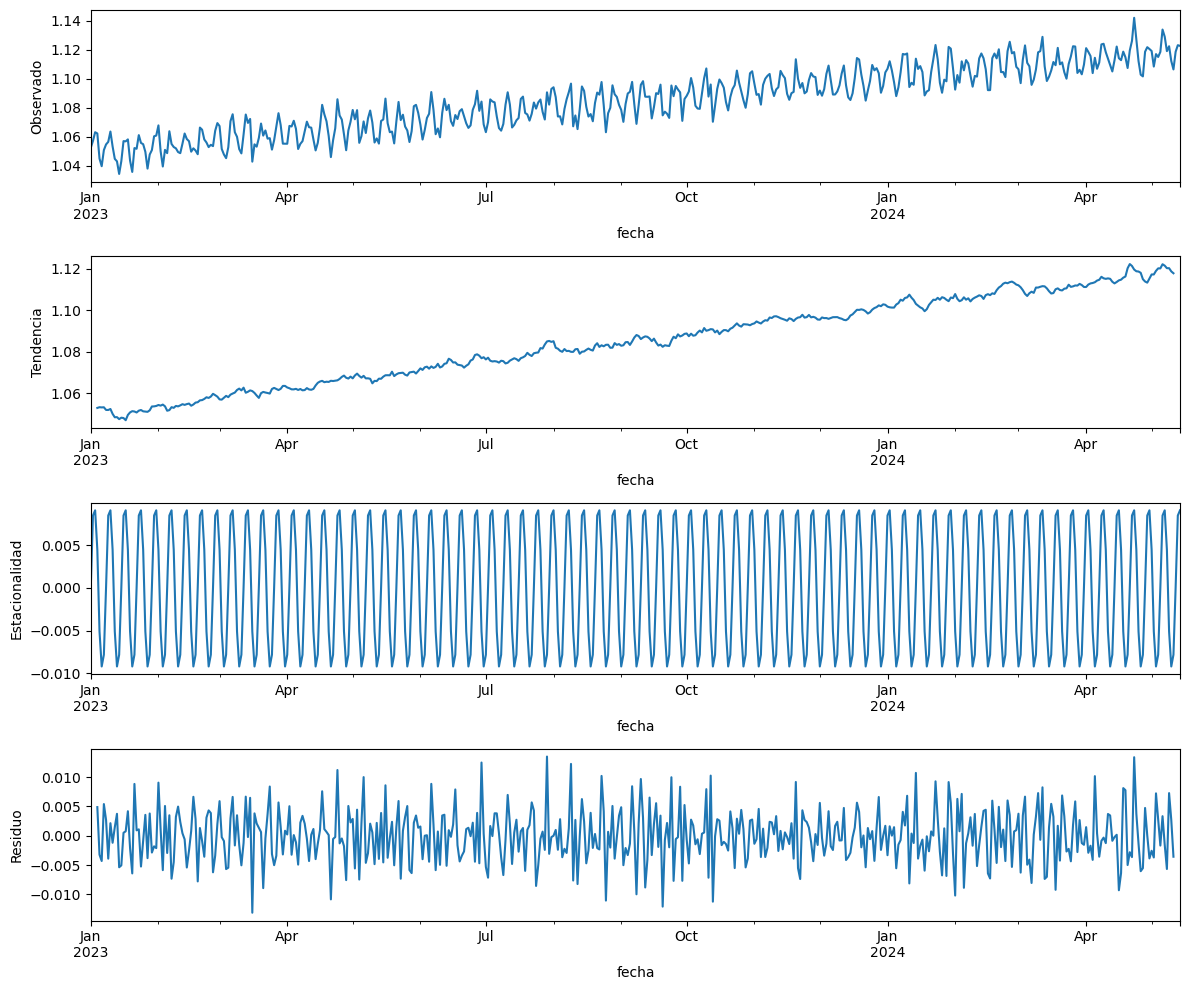


--- PRUEBA ADF (serie original) ---
Estadístico ADF: -0.4732
p-valor: 0.8971
La serie NO es estacionaria (no rechazamos H0)

--- PRUEBA ADF (primera diferencia) ---
Estadístico ADF: -12.0459
p-valor: 0.0000
La serie diferenciada es estacionaria.


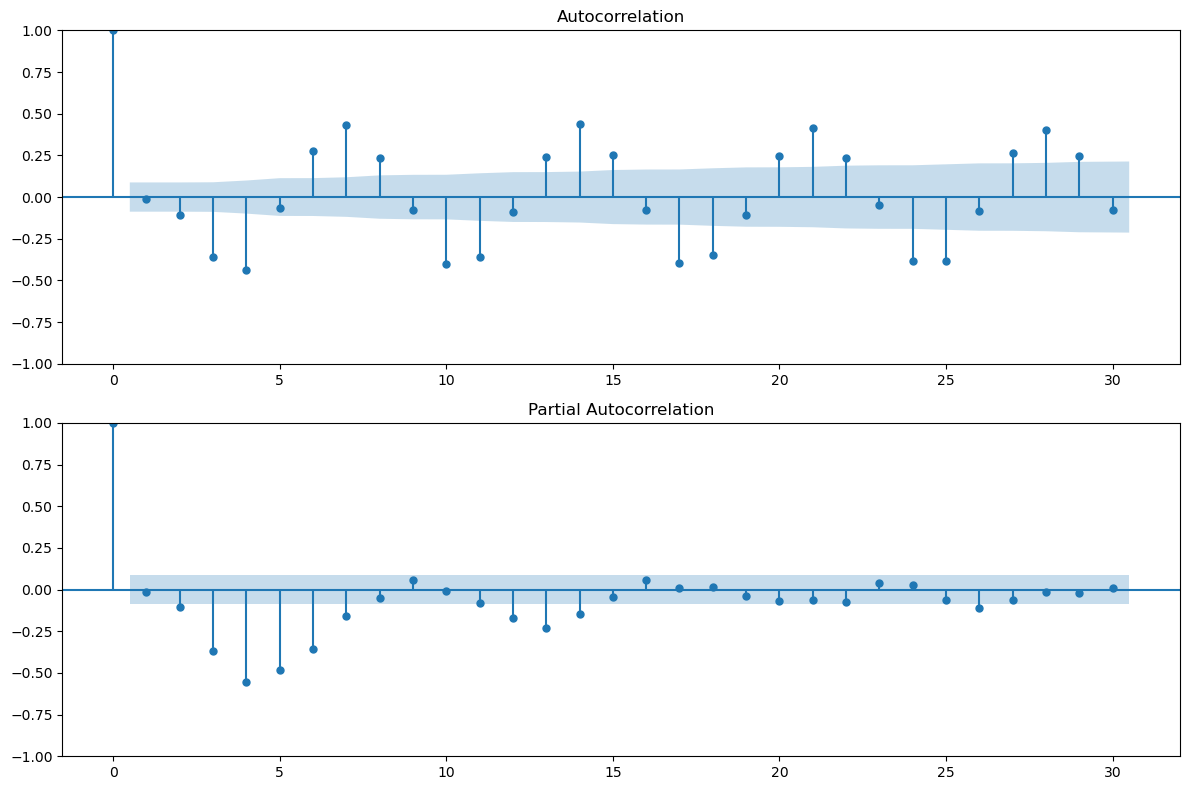


--- RESUMEN DEL MODELO ARIMA(1,1,1) ---
                               SARIMAX Results                                
Dep. Variable:                 precio   No. Observations:                  500
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1630.358
Date:                Tue, 17 Feb 2026   AIC                          -3254.715
Time:                        10:56:13   BIC                          -3242.078
Sample:                    01-01-2023   HQIC                         -3249.756
                         - 05-14-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0072      3.266     -0.002      0.998      -6.408       6.394
ma.L1         -0.0072      3.269     -0.002      0.998      -6.414       6.399
sigma2     

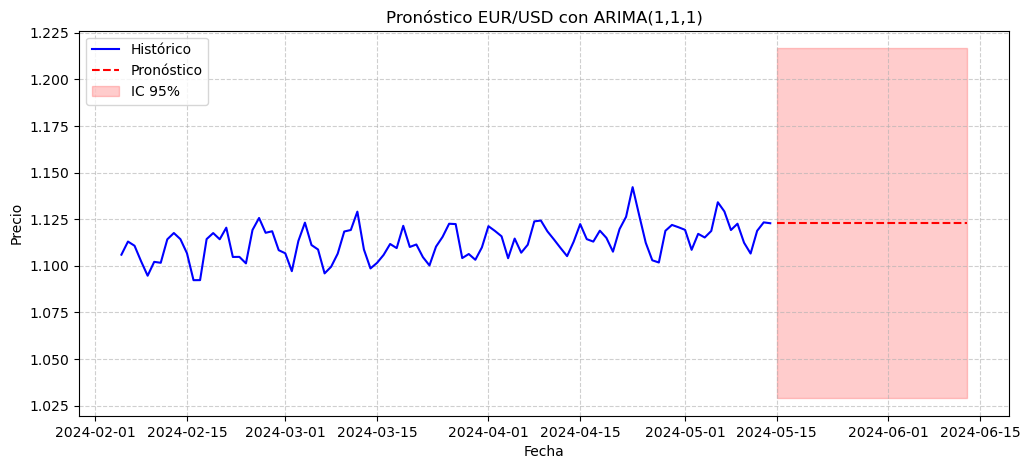


--- INTERPRETACIÓN PARA EL NEGOCIO ---
El modelo ARIMA captura la tendencia y la estructura de autocorrelación de la serie.
El pronóstico, con su intervalo de confianza, permite estimar rangos probables del tipo de cambio.
Esto es útil para:
- Cobertura cambiaria: empresas que necesitan protegerse de fluctuaciones.
- Trading algorítmico: generar señales de compra/venta basadas en desviaciones del pronóstico.
- Gestión de riesgos: calcular el Valor en Riesgo (VaR) asumiendo cierta evolución del FX.


In [1]:
# ============================================
# SERIES DE TIEMPO EN FINANZAS
# Análisis de tipo de cambio EUR/USD
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Fijar semilla
np.random.seed(42)

# --------------------------------------------
# 1. Simular datos diarios de EUR/USD (2 años)
# --------------------------------------------
dias = 500
fecha_inicio = '2023-01-01'
fechas = pd.date_range(start=fecha_inicio, periods=dias, freq='D')

# Componentes:
# - Tendencia: ligera apreciación del euro (sube 0.0002 por día)
# - Estacionalidad: ciclo semanal (los viernes suele subir, lunes bajar)
# - Ruido aleatorio (movimientos diarios)

tendencia = np.linspace(1.05, 1.12, dias)  # de 1.05 a 1.12 en 2 años
estacionalidad = 0.01 * np.sin(2 * np.pi * np.arange(dias) / 7)  # ciclo semanal
ruido = np.random.normal(0, 0.005, dias)  # volatilidad diaria

precio = tendencia + estacionalidad + ruido

# Crear DataFrame
df = pd.DataFrame({'fecha': fechas, 'precio': precio})
df.set_index('fecha', inplace=True)

print("Datos simulados de EUR/USD (primeras 10 filas):")
print(df.head(10))

# --------------------------------------------
# 2. Visualización de la serie completa
# --------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(df.index, df['precio'], color='blue', linewidth=1)
plt.title('Tipo de cambio EUR/USD (simulado)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --------------------------------------------
# 3. Descomposición de la serie (tendencia + estacionalidad + residuo)
# --------------------------------------------
# La descomposición aditiva es apropiada cuando la magnitud de las fluctuaciones estacionales no varía con el nivel de la serie
descomposicion = seasonal_decompose(df['precio'], model='additive', period=7)  # periodo semanal

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,10))
descomposicion.observed.plot(ax=ax1)
ax1.set_ylabel('Observado')
descomposicion.trend.plot(ax=ax2)
ax2.set_ylabel('Tendencia')
descomposicion.seasonal.plot(ax=ax3)
ax3.set_ylabel('Estacionalidad')
descomposicion.resid.plot(ax=ax4)
ax4.set_ylabel('Residuo')
plt.tight_layout()
plt.show()

# Interpretación: la tendencia es clara, la estacionalidad semanal se aprecia, y el residuo es ruido blanco.

# --------------------------------------------
# 4. Prueba de estacionariedad (Dickey-Fuller aumentado)
# --------------------------------------------
# Para modelos ARIMA necesitamos series estacionarias (media y varianza constantes)
resultado_adf = adfuller(df['precio'])
print('\n--- PRUEBA ADF (serie original) ---')
print(f'Estadístico ADF: {resultado_adf[0]:.4f}')
print(f'p-valor: {resultado_adf[1]:.4f}')
if resultado_adf[1] < 0.05:
    print('La serie es estacionaria (rechazamos H0)')
else:
    print('La serie NO es estacionaria (no rechazamos H0)')

# En este caso, como hay tendencia, seguramente no sea estacionaria. Aplicamos primera diferencia.
df['precio_diff'] = df['precio'].diff().dropna()

resultado_adf_diff = adfuller(df['precio_diff'].dropna())
print('\n--- PRUEBA ADF (primera diferencia) ---')
print(f'Estadístico ADF: {resultado_adf_diff[0]:.4f}')
print(f'p-valor: {resultado_adf_diff[1]:.4f}')
if resultado_adf_diff[1] < 0.05:
    print('La serie diferenciada es estacionaria.')
else:
    print('La serie diferenciada aún no es estacionaria (harían falta más diferencias).')

# --------------------------------------------
# 5. Funciones de autocorrelación (ACF y PACF) para identificar órdenes ARIMA
# --------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['precio_diff'].dropna(), ax=ax1, lags=30)
plot_pacf(df['precio_diff'].dropna(), ax=ax2, lags=30)
plt.tight_layout()
plt.show()

# Interpretación: Para identificar p (AR) y q (MA). En la práctica se suele usar auto_arima o criterios AIC.

# --------------------------------------------
# 6. Ajuste de modelo ARIMA(1,1,1) (p=1, d=1, q=1) - ejemplo simple
# --------------------------------------------
modelo = ARIMA(df['precio'], order=(1,1,1))
resultado = modelo.fit()
print('\n--- RESUMEN DEL MODELO ARIMA(1,1,1) ---')
print(resultado.summary())

# --------------------------------------------
# 7. Pronóstico a 30 días
# --------------------------------------------
pronostico = resultado.forecast(steps=30)
fechas_futuras = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(12,5))
plt.plot(df.index[-100:], df['precio'][-100:], label='Histórico', color='blue')
plt.plot(fechas_futuras, pronostico, label='Pronóstico', color='red', linestyle='--')
plt.fill_between(fechas_futuras, 
                 pronostico - 1.96*np.std(resultado.resid), 
                 pronostico + 1.96*np.std(resultado.resid), 
                 color='red', alpha=0.2, label='IC 95%')
plt.title('Pronóstico EUR/USD con ARIMA(1,1,1)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --------------------------------------------
# 8. Interpretación de negocio
# --------------------------------------------
print("\n--- INTERPRETACIÓN PARA EL NEGOCIO ---")
print("El modelo ARIMA captura la tendencia y la estructura de autocorrelación de la serie.")
print("El pronóstico, con su intervalo de confianza, permite estimar rangos probables del tipo de cambio.")
print("Esto es útil para:")
print("- Cobertura cambiaria: empresas que necesitan protegerse de fluctuaciones.")
print("- Trading algorítmico: generar señales de compra/venta basadas en desviaciones del pronóstico.")
print("- Gestión de riesgos: calcular el Valor en Riesgo (VaR) asumiendo cierta evolución del FX.")